In [1]:
import numpy as np
import matplotlib.pyplot as plt

from random import randrange

import torch
from torch.nn import Module, Sequential, Linear, Tanh
from torch.distributions import Categorical
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device= "cpu"
print(device)

cpu


/home/max/anaconda3/envs/ML/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
num_piles = 1
pile_sampler = Categorical(torch.tensor([1]))
pile_sampler2 = Categorical(torch.tensor([1]))
normal_init = MultivariateNormal(torch.tensor([[1 for i in range(100)]]).float(), 0.3*torch.stack([torch.eye(100) for i in range(num_piles)]))
normal_target = MultivariateNormal(torch.tensor([np.multiply([0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,1,0,0,0,0, 0,0,0,0,1,1,1,0,0,0, 0,0,1,1,1,1,1,1,1,0, 0,1,1,1,1,1,1,1,1,1, 0,1,1,1,1,1,1,1,1,1, 0,0,1,1,1,1,1,1,1,0, 0,0,0,1,1,1,1,1,0,0, 0,0,0,0,0,1,0,0,0,0, 0,0,0,0,0,0,0,0,0,0], 2)]).float(), .01 *torch.stack([torch.eye(100)]))
sampler_init = MixtureSameFamily(pile_sampler, normal_init)
sampler_target = MixtureSameFamily(pile_sampler2, normal_target)

/tmp/ipykernel_12078/1867730682.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  normal_target = MultivariateNormal(torch.tensor([np.multiply([0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,1,0,0,0,0, 0,0,0,0,1,1,1,0,0,0, 0,0,1,1,1,1,1,1,1,0, 0,1,1,1,1,1,1,1,1,1, 0,1,1,1,1,1,1,1,1,1, 0,0,1,1,1,1,1,1,1,0, 0,0,0,1,1,1,1,1,0,0, 0,0,0,0,0,1,0,0,0,0, 0,0,0,0,0,0,0,0,0,0], 2)]).float(), .01 *torch.stack([torch.eye(100)]))


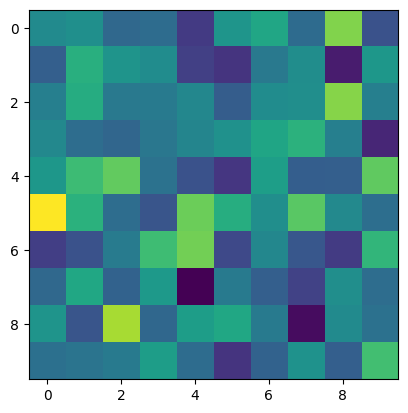

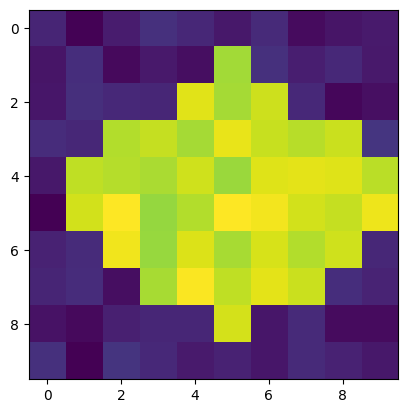

tensor([[ 1.1006,  1.1598,  0.6997,  0.7376,  0.2089,  1.2326,  1.4348,  0.7309,
          2.0636,  0.4515],
        [ 0.5933,  1.5423,  1.2156,  1.1277,  0.2717,  0.1571,  0.8848,  1.1409,
         -0.0604,  1.2458],
        [ 0.9681,  1.5145,  0.8934,  0.9006,  1.0566,  0.5768,  1.1250,  1.1549,
          2.0882,  0.9686],
        [ 1.0714,  0.7503,  0.6693,  0.8668,  1.0308,  1.1812,  1.4204,  1.5806,
          0.9631,  0.0291],
        [ 1.2520,  1.7001,  1.9194,  0.8108,  0.4526,  0.1738,  1.3437,  0.5788,
          0.5981,  1.9061],
        [ 2.6144,  1.5669,  0.7569,  0.4847,  1.9688,  1.5263,  1.1438,  1.8689,
          1.0783,  0.7686],
        [ 0.2566,  0.4514,  0.9215,  1.7180,  1.9966,  0.3533,  1.0632,  0.5041,
          0.2197,  1.6225],
        [ 0.6925,  1.4421,  0.6272,  1.2823, -0.2819,  0.9010,  0.5987,  0.2886,
          1.1516,  0.7588],
        [ 1.2167,  0.4801,  2.2409,  0.6889,  1.3272,  1.4408,  0.9153, -0.1872,
          1.1071,  0.7984],
        [ 0.7874,  

In [4]:
samples_init=sampler_init.sample([8000]).to(device)
samples_target=sampler_target.sample([8000]).to(device)

pairs_1 = torch.stack([samples_init, samples_target], axis=1)

plt.imshow(samples_init[0].reshape(10, 10).cpu().numpy())
plt.show()
plt.imshow(samples_target[0].reshape(10,10).cpu().numpy())
plt.show()

print(samples_init[0].reshape(10,10))
print(samples_target[0].reshape(10,10))

In [5]:
class MLP(Module):
    def __init__(self, input_dim, hidden_num):
        super().__init__()
        self.NN = Sequential(Linear(input_dim + 1, hidden_num, bias=True),
                            Tanh(),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Linear(hidden_num, input_dim, bias=True)
                            )
    
    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=1)
        x = self.NN(inputs)

        return x

In [6]:
class RectifiedFlow(Module):
    def __init__(self, v_model):
        super().__init__()
        self.v_model = v_model.to(device)

    def get_train_tuple(self, z0, z1):
        # random times
        t = torch.rand((z0.shape[0], 1)).to(device)
        # linear interpolation
        z_t = t* z1 + (1-t) * z0
        # connection line
        target = z1 - z0

        return z_t, t, target


    def sample_ode(self, z0, num_steps):
        trajectory = []
        trajectory.append(z0.detach().clone())

        batchsize = z0.shape[0]

        dt = 1./num_steps
        z = z0.detach().clone()
        for i in range(num_steps):
            t = torch.ones((batchsize, 1)).to(device) * i /num_steps
            pred = self.v_model(z, t)
            z = z.detach().clone() + pred * dt

            trajectory.append(z.detach().clone())

        return trajectory


In [7]:
def train_rectified_flow(rectified_flow, optimizer, pairs, batchsize, inner_iters):
    loss_curve = []
    for i in range(inner_iters + 1):
        optimizer.zero_grad()
        indeces = torch.randperm(len(pairs))[:batchsize]
        batch = pairs[indeces]
        z0 = batch[:, 0].detach().clone()
        z1 = batch[:, 1].detach().clone()
        z_t, t, target = rectified_flow.get_train_tuple(z0, z1)
        #print(rectified_flow.v_model.device)

        pred = rectified_flow.v_model(z_t, t)
        loss = (target- pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
        loss = loss.mean()
        loss.backward()

        optimizer.step()
        loss_curve.append(loss.item())

    return rectified_flow, loss_curve

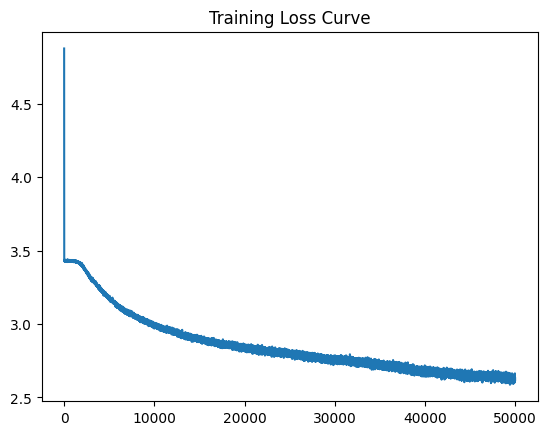

In [8]:
iterations = 50000
batchsize = 2048
input_dim = 100

v_model_1 = MLP(input_dim, hidden_num=110)
rectified_flow_1 = RectifiedFlow(v_model_1)
optimizer = torch.optim.SGD(rectified_flow_1.v_model.parameters(), lr=5e-3)

rectified_flow_1, loss_curve_1 = train_rectified_flow(rectified_flow_1, optimizer, pairs_1, batchsize, iterations)
plt.plot(np.log(loss_curve_1))
plt.title("Training Loss Curve")
plt.show()

In [9]:
flow_1 = rectified_flow_1.sample_ode(samples_init, 100)
pairs_2 = torch.stack([samples_init, flow_1[:][-1]], axis= 1)

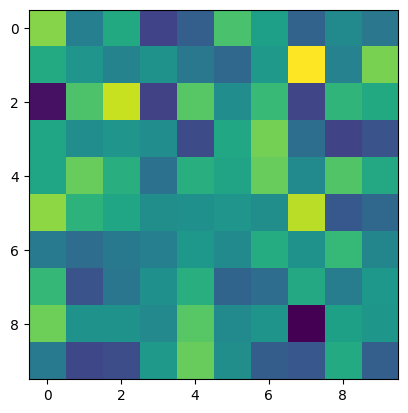

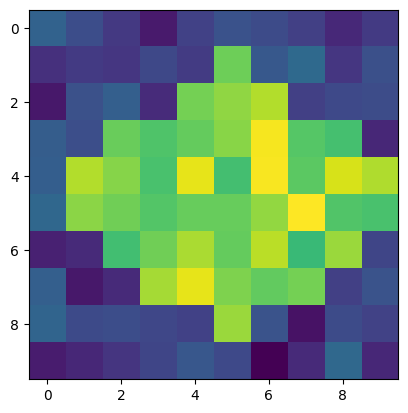

In [10]:
curr = 100
plt.imshow(samples_init[curr].reshape(10,10).cpu().numpy())
plt.show()
plt.imshow(flow_1[-1][curr].reshape(10,10).cpu().numpy())

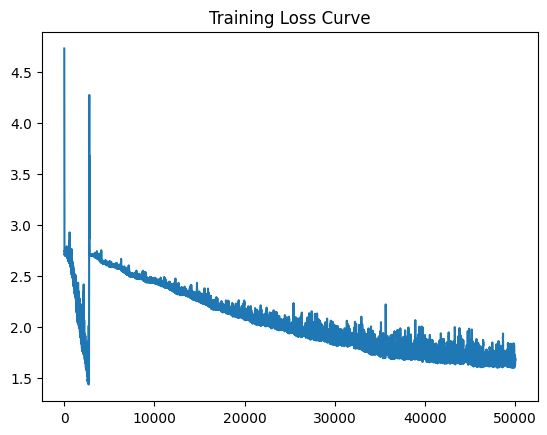

In [11]:
v_model_2 = MLP(input_dim, hidden_num=110)
rectified_flow_2 = RectifiedFlow(v_model_2)
optimizer_2 = torch.optim.Adam(rectified_flow_2.v_model.parameters(), lr=5e-3)

rectified_flow_2, loss_curve_2 = train_rectified_flow(rectified_flow_2, optimizer_2, pairs_2, batchsize, iterations)
plt.plot(np.log(loss_curve_2))
plt.title("Training Loss Curve")
plt.show()

In [12]:
flow_2 = rectified_flow_2.sample_ode(samples_init, 100)
pairs_3 = torch.stack([samples_init, flow_2[:][-1]], axis= 1)

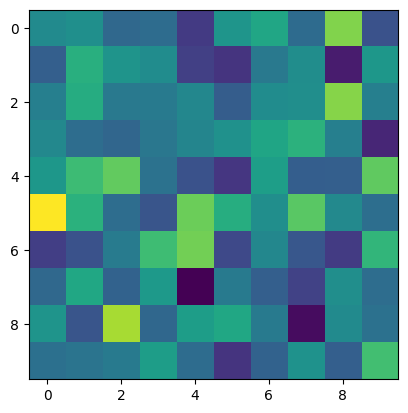

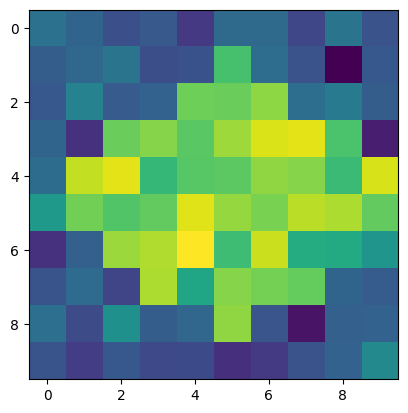

In [14]:
curr = 0
plt.imshow(samples_init[curr].reshape(10,10).cpu().numpy())
plt.show()
plt.imshow(flow_2[-1][curr].reshape(10,10).cpu().numpy())

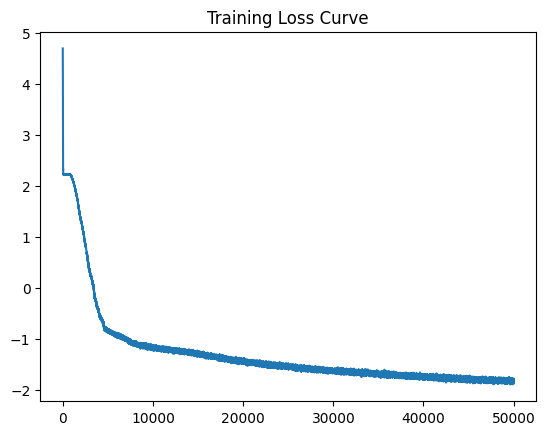

In [15]:
v_model_3 = MLP(input_dim, hidden_num=110)
rectified_flow_3 = RectifiedFlow(v_model_3)
optimizer_3 = torch.optim.Adam(rectified_flow_3.v_model.parameters(), lr=5e-4)

rectified_flow_3, loss_curve_3 = train_rectified_flow(rectified_flow_3, optimizer_3, pairs_3, batchsize, iterations)
plt.plot(np.log(loss_curve_3))
plt.title("Training Loss Curve")
plt.show()

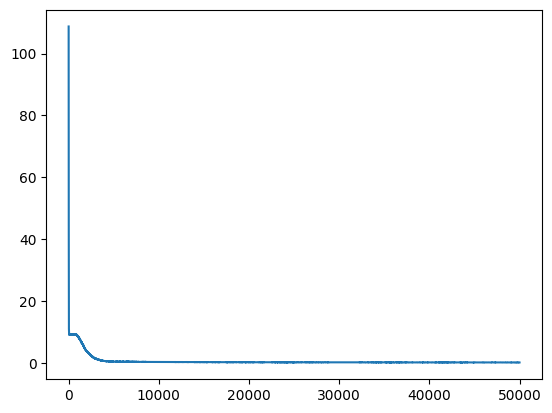

In [16]:
plt.plot(loss_curve_3)

In [17]:
flow_3 = rectified_flow_3.sample_ode(samples_init, 100)

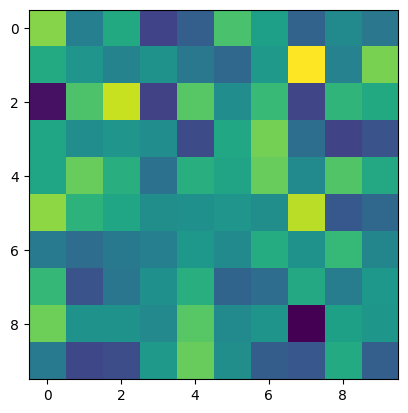

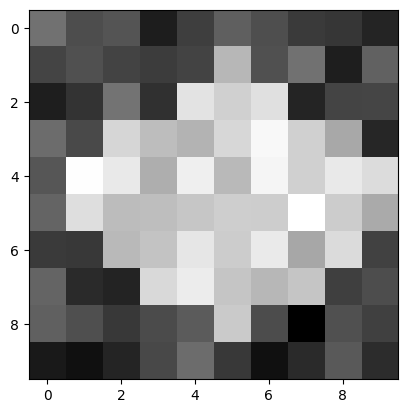

tensor([[ 0.6010,  0.0777,  0.1825, -0.6219, -0.1407,  0.3394,  0.0963, -0.2072,
         -0.2654, -0.5191],
        [-0.0572,  0.1234, -0.0718, -0.1512, -0.0760,  1.6205,  0.1137,  0.6233,
         -0.6176,  0.3764],
        [-0.6161, -0.2973,  0.6291, -0.3484,  2.2859,  1.9879,  2.2238, -0.5051,
         -0.0605, -0.0460],
        [ 0.5307,  0.0355,  2.0719,  1.7096,  1.5615,  2.0919,  2.5821,  1.9926,
          1.4087, -0.4897],
        [ 0.2146,  2.6652,  2.3530,  1.4971,  2.4477,  1.6624,  2.5284,  1.9971,
          2.3551,  2.1663],
        [ 0.4152,  2.2002,  1.6967,  1.7228,  1.8500,  1.9597,  1.9468,  2.6856,
          1.9389,  1.4354],
        [-0.2030, -0.2284,  1.6609,  1.8007,  2.3058,  1.9274,  2.3775,  1.3979,
          2.1577, -0.1051],
        [ 0.4117, -0.4410, -0.5355,  2.1210,  2.4058,  1.8300,  1.6214,  1.8377,
         -0.1343,  0.0823],
        [ 0.3489,  0.1036, -0.2086,  0.0425,  0.2842,  1.9025,  0.0559, -1.0562,
          0.1205, -0.1117],
        [-0.6779, -

In [21]:
curr = 100
plt.imshow(samples_init[curr].reshape(10,10).cpu().numpy())
plt.show()
plt.imshow(flow_3[-1][curr].reshape(10,10).cpu().numpy(), cmap="gray")
plt.show()
print(flow_3[-1][curr].reshape(10,10))